In [4]:
#Connect to my google drive
#This must be run before reading any .csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries
import cudf  #For GPU
import cupy as cp #For GP
import pandas as pd
import numpy as np
import time, subprocess #For execution time measuremen ts
from cuml.decomposition import IncrementalPCA as cuIncPCA #GPU PCA
from sklearn.decomposition import
from scipy.stats import skew #For pre-pipleine distribution step
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

In [12]:
#Read in dataframe using pandas for visualization
#This is the most time-consuming step because it's not utilizing gpu
#For the heavier calculations, the .csv file is re-read as a cudf
print("Loading in .csv file as pandas")
csv_filepath = "/content/drive/MyDrive/TCGA-BRCA_samples_labeled.csv"
df = pd.read_csv(csv_filepath)

Loading in .csv file as pandas


In [18]:
df = df.drop(columns = ['Unnamed: 0'], axis = 0)

In [15]:
#It is assumed that the data has already been pre-processed at this point
#The following is just for visualization purposes

#Because there are tens of thousands of features, the following

def feature_skewness_summary(df, normal_threshold=0.5):
    skewness = df.apply(skew, nan_policy='omit')  # compute skewness per feature

    # Classification
    normal_count = (skewness.abs() < normal_threshold).sum()
    right_count = (skewness > normal_threshold).sum()
    left_count = (skewness < -normal_threshold).sum()

    # Build summary table
    summary = pd.DataFrame({
        "Distribution Type": ["Normal", "Left-Skewed", "Right-Skewed"],
        "Count": [normal_count, left_count, right_count]
    })

    return summary


In [19]:
summary_table = feature_skewness_summary(df)
print(summary_table)

  Distribution Type  Count
0            Normal  19835
1       Left-Skewed   5228
2      Right-Skewed  32985


In [28]:
def plot_distribution_pie(summary_table, title="Distribution Types"):
    plt.figure(figsize=(6,6))
    plt.pie(
        summary_table['Count'],
        labels=summary_table['Distribution Type'],
        autopct='%1.1f%%',
        startangle=140,
        wedgeprops={'edgecolor': 'black'}
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

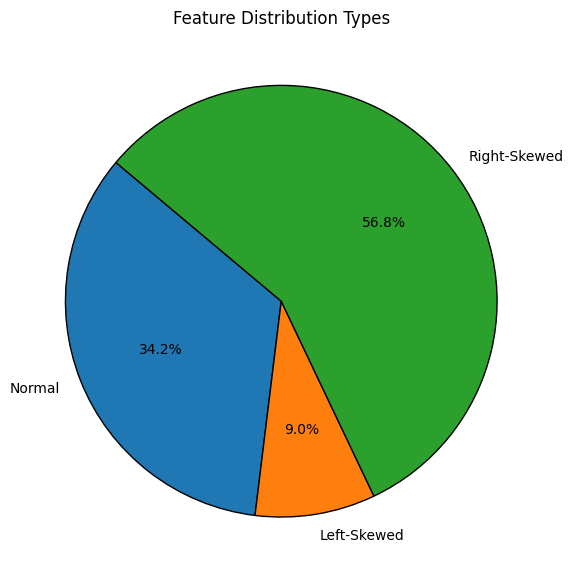

In [23]:
plot_distribution_pie(summary_table)

In [27]:
def sample_skewness_summary(df, normal_threshold=0.5, log_transform=False):
    data = df.to_numpy()
    if log_transform:
        data = np.log2(data + 1)  # compress right tails

    skewness = skew(data, axis=1, nan_policy='omit')

    # Classify
    normal_mask = np.abs(skewness) < normal_threshold
    right_mask = skewness > normal_threshold
    left_mask = skewness < -normal_threshold

    summary = pd.DataFrame({
        "Distribution Type": ["Normal", "Left-Skewed", "Right-Skewed"],
        "Count": [normal_mask.sum(), left_mask.sum(), right_mask.sum()]
    })
    return summary

In [26]:
sample_summary = sample_skewness_summary(df)
sample_summary

,Distribution Type,Count
0,Normal,0
1,Left-Skewed,0
2,Right-Skewed,1219


In [30]:
raw_sample_summary = sample_skewness_summary(df, log_transform=False)
#plot_distribution_pie(raw_sample_summary, title="Sample Skewness (Raw Data)")

# Log-transformed data
# Most genomic features are going to be heavily right-skewed so it's best to check the log transform skews as well
# After a log transform, most distributions should be normal

log_sample_summary = sample_skewness_summary(df, log_transform=True)
#plot_distribution_pie(log_sample_summary, title="Sample Skewness (Log2 Transformed)")
raw_sample_summary

,Distribution Type,Count
0,Normal,0
1,Left-Skewed,0
2,Right-Skewed,1219


In [31]:
log_sample_summary

,Distribution Type,Count
0,Normal,944
1,Left-Skewed,1
2,Right-Skewed,274


In [36]:
def feature_label_correlation_summary(df, labels, step=0.1):

    # Compute correlations
    corr = df.corrwith(pd.Series(labels))

    # Create bins from -1 to 1 in steps
    bins = np.arange(-1, 1 + step, step)

    # Bin the correlations
    categories = pd.cut(corr, bins=bins, right=True, include_lowest=True)
    counts = categories.value_counts().sort_index()

    # Format for table
    summary = pd.DataFrame({
        "Correlation Range": counts.index.astype(str),
        "Count": counts.values
    })

    return summary



In [37]:
label_series = df['label']  # replace with your target column
correlation_summary = feature_label_correlation_summary(df, label_series, step=0.1)
print(correlation_summary)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


    Correlation Range  Count
0      (-1.001, -0.9]      0
1        (-0.9, -0.8]      0
2        (-0.8, -0.7]      0
3        (-0.7, -0.6]     72
4        (-0.6, -0.5]    429
5        (-0.5, -0.4]    890
6        (-0.4, -0.3]   1799
7        (-0.3, -0.2]   3269
8        (-0.2, -0.1]   6191
9   (-0.1, -2.22e-16]  14781
10   (-2.22e-16, 0.1]  22081
11         (0.1, 0.2]   5125
12         (0.2, 0.3]   2202
13         (0.3, 0.4]    821
14         (0.4, 0.5]    250
15         (0.5, 0.6]    122
16         (0.6, 0.7]     15
17         (0.7, 0.8]      0
18         (0.8, 0.9]      0
19         (0.9, 1.0]      0


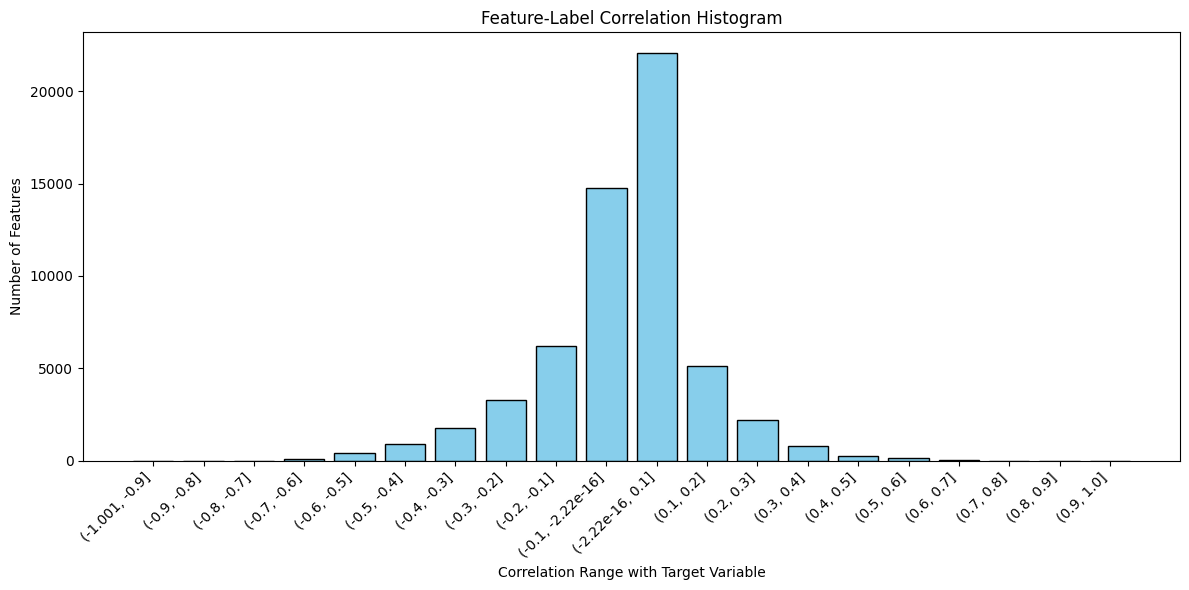

In [41]:
#Plot as histogram

def plot_correlation_histogram(summary_table, title="Feature-Label Correlation Histogram"):
    # Extract data
    ranges = summary_table['Correlation Range'].astype(str)
    counts = summary_table['Count']

    # Plot
    plt.figure(figsize=(12,6))
    plt.bar(ranges, counts, color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Correlation Range with Target Variable")
    plt.ylabel("Number of Features")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_correlation_histogram(correlation_summary)

In [42]:
def extract_high_corr_features(df, labels, threshold=0.5):

    #This method takes a subset of df based on features that show high correlation with the target variable
    #This df_corr will be used to benchmark the downstream classifiers
    #the df_corr is not put through the PCA pipeline

    corr = df.corrwith(pd.Series(labels)) #Computes correlations
    selected_features = corr[abs(corr) > threshold].index.tolist() #Indexes select features
    df_corr = df[selected_features] #Subset of df based on highly correlated features

    return df_corr, selected_features



In [43]:

df_corr, high_corr_genes = extract_high_corr_features(df, label_series, threshold=0.5)
print(f"Selected {len(high_corr_genes)} features with |correlation| > 0.5")

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Selected 639 features with |correlation| > 0.5


In [45]:
def corr_benchmark(X, y, use_pca=False, n_components=20):
    # Optional PCA
    if use_pca:
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Classifiers
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    lr = LogisticRegression(max_iter=1000, random_state=42)
    svm = SVC(probability=True, random_state=42)
    voting = VotingClassifier(
        estimators=[('rf', rf), ('lr', lr), ('svm', svm)],
        voting='soft'
    )

    classifiers = {
        'Random Forest': rf,
        'Logistic Regression': lr,
        'SVM': svm,
        'Voting': voting
    }

    # Train & evaluate
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        results[name] = f1

    return pd.DataFrame(list(results.items()), columns=['Classifier', 'F1-Score'])




In [49]:
df_corr = df_corr.drop(columns = ['label'], axis = 0)

In [51]:
df_corr.columns

Index(['ENSG00000000005.6', 'ENSG00000004776.13', 'ENSG00000004799.8',
       'ENSG00000004846.16', 'ENSG00000007314.12', 'ENSG00000010319.7',
       'ENSG00000011426.11', 'ENSG00000013293.6', 'ENSG00000013810.20',
       'ENSG00000016602.9',
       ...
       'ENSG00000287115.1', 'ENSG00000287148.1', 'ENSG00000287373.1',
       'ENSG00000287417.1', 'ENSG00000287652.1', 'ENSG00000287666.1',
       'ENSG00000287693.1', 'ENSG00000287956.1', 'ENSG00000287988.1',
       'ENSG00000288048.1'],
      dtype='object', length=638)

In [50]:

f1_raw = corr_benchmark(df_corr, label_series, use_pca=False)
f1_pca = corr_benchmark(df_corr, label_series, use_pca=True, n_components=20)
print("Raw Features:\n", f1_raw)
print("PCA Features:\n", f1_pca)

Raw Features:
             Classifier  F1-Score
0        Random Forest  0.997763
1  Logistic Regression  1.000000
2                  SVM  1.000000
3               Voting  1.000000
PCA Features:
             Classifier  F1-Score
0        Random Forest  0.997763
1  Logistic Regression  1.000000
2                  SVM  1.000000
3               Voting  1.000000


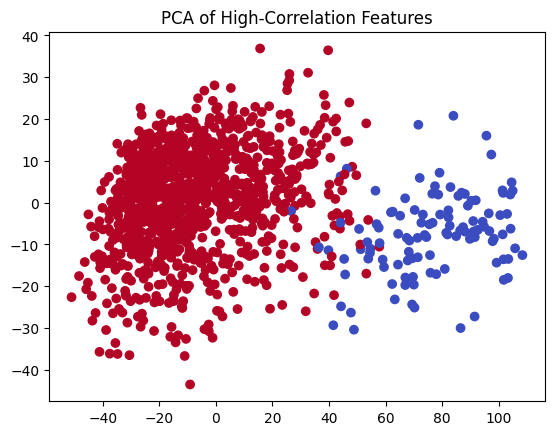

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2).fit_transform(df_corr)
plt.scatter(pca[:,0], pca[:,1], c=label_series, cmap='coolwarm')
plt.title("PCA of High-Correlation Features")
plt.show()

In [56]:
def cross_val_classifiers(X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Classifiers
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    lr = LogisticRegression(max_iter=1000, random_state=42)
    svm = SVC(probability=True, random_state=42)
    voting = VotingClassifier(
        estimators=[('rf', rf), ('lr', lr), ('svm', svm)],
        voting='soft'
    )

    classifiers = {
        'Random Forest': rf,
        'Logistic Regression': lr,
        'SVM': svm,
        'Voting': voting
    }

    results = []
    for name, clf in classifiers.items():
        scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')
        results.append({
            'Classifier': name,
            'Mean F1': round(scores.mean(), 4),
            'Std F1': round(scores.std(), 4)
        })

    return pd.DataFrame(results)



In [58]:

cv_results = cross_val_classifiers(df_corr, label_series)
print(cv_results)

            Classifier  Mean F1  Std F1
0        Random Forest   0.9968  0.0023
1  Logistic Regression   0.9986  0.0011
2                  SVM   0.9977  0.0014
3               Voting   0.9977  0.0014


In [55]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.ensemble import RandomForestClassifier
scores = cross_val_score(RandomForestClassifier(), df_corr, label_series, cv=cv, scoring='f1')
print("Mean F1:", scores.mean(), "Std:", scores.std())

Mean F1: 0.9963800628289345 Std: 0.002313281588998455
